In [1]:
!pip install livelossplot
!pip install keras_tuner

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display, HTML
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import io
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import layers
from kerastuner import HyperModel
import keras_tuner
from kerastuner.tuners import BayesianOptimization

## 1. Data preparation

### 1.1 Load Data

In [4]:
train_data = pd.read_csv("/kaggle/input/fashion1/fashion-mnist_train.csv")
test_data = pd.read_csv("/kaggle/input/fashion1/fashion-mnist_test.csv")

train_data.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


### 1.2 Split the training data into training and validation sets

In [10]:
X_train_val = train_data.iloc[:, 1:]
y_train_val = train_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]

# Split the training data into training and validation sets as the oriagial dataset already splited
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

### 1.3 Data Exploration

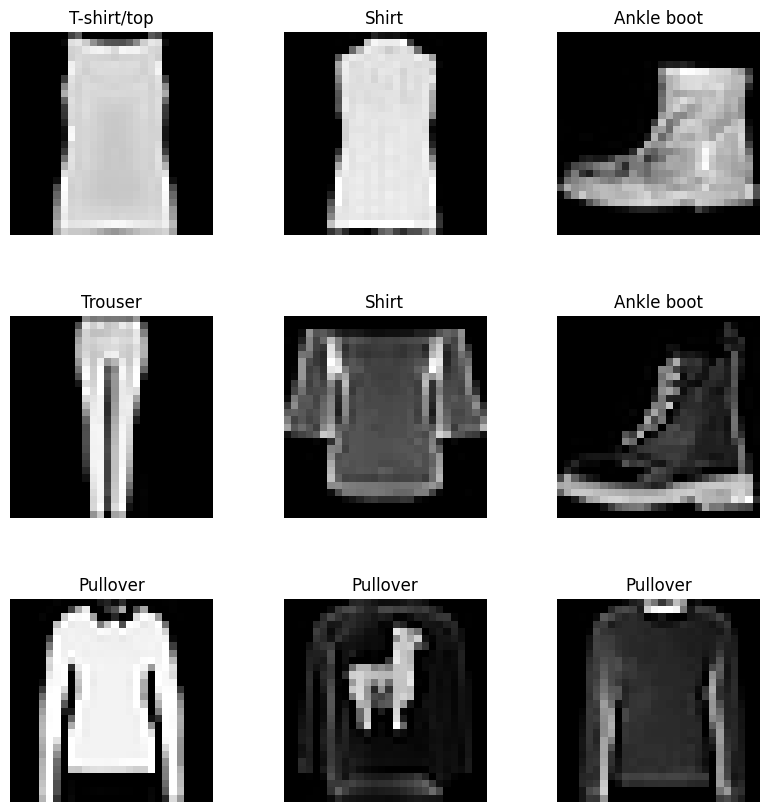

In [11]:
# Visualizing the Data
# Function to visualize images
def visualize_data(images, labels):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in np.arange(0, 9):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images.iloc[index].values.reshape(28, 28), cmap='gray')
        axes[i].set_title(class_names[int(labels.iloc[index])], fontsize=12)
        axes[i].axis('off')
    plt.subplots_adjust(hspace=0.4)

# Select images and labels to visualize
visualize_data(X_train, y_train)


In [12]:
# Check the class distribution
# Create a dictionary for each type of label
labels = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Print class distribution
    print("Class Distribution:")
    for label_id, count in label_counts.items():
        label_name = labels.get(label_id, "Unknown")
        percent = (count / total_samples) * 100
        print(f"{label_name:<20s}:   {count} samples or {percent:.2f}%")

# Call the function with train_data DataFrame
get_classes_distribution(train_data)

Class Distribution:
Pullover            :   6000 samples or 10.00%
Ankle Boot          :   6000 samples or 10.00%
Shirt               :   6000 samples or 10.00%
T-shirt/top         :   6000 samples or 10.00%
Dress               :   6000 samples or 10.00%
Coat                :   6000 samples or 10.00%
Sandal              :   6000 samples or 10.00%
Bag                 :   6000 samples or 10.00%
Sneaker             :   6000 samples or 10.00%
Trouser             :   6000 samples or 10.00%


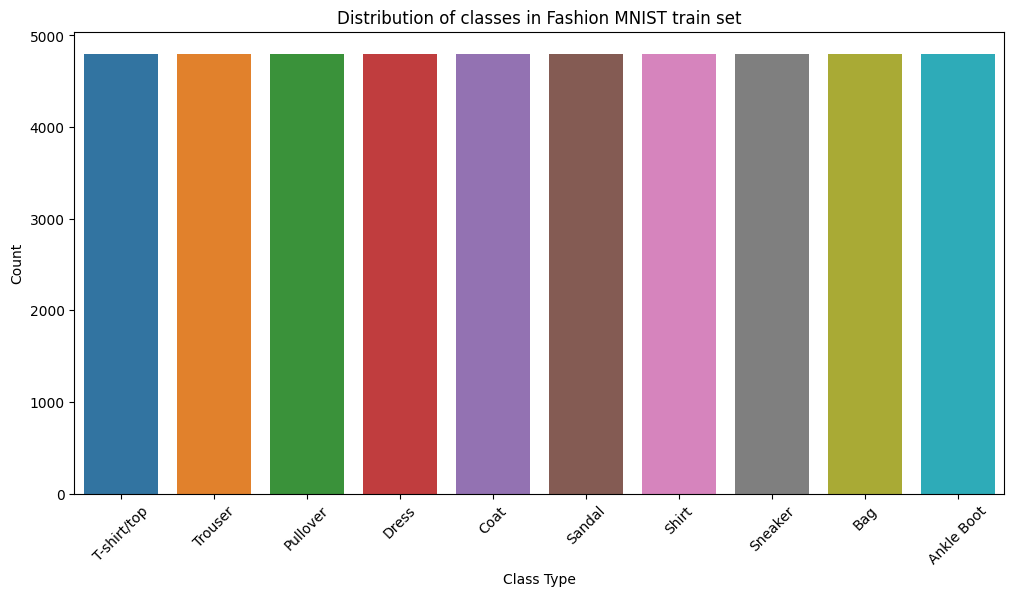

In [13]:
# check the class distribution for training set
# Count of each label
label_counts = np.bincount(y_train)

# Convert to dict for ease of use
label_counts_dict = {labels[i]: count for i, count in enumerate(label_counts)}

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_dict.keys()), y=list(label_counts_dict.values()))
plt.title('Distribution of classes in Fashion MNIST train set')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

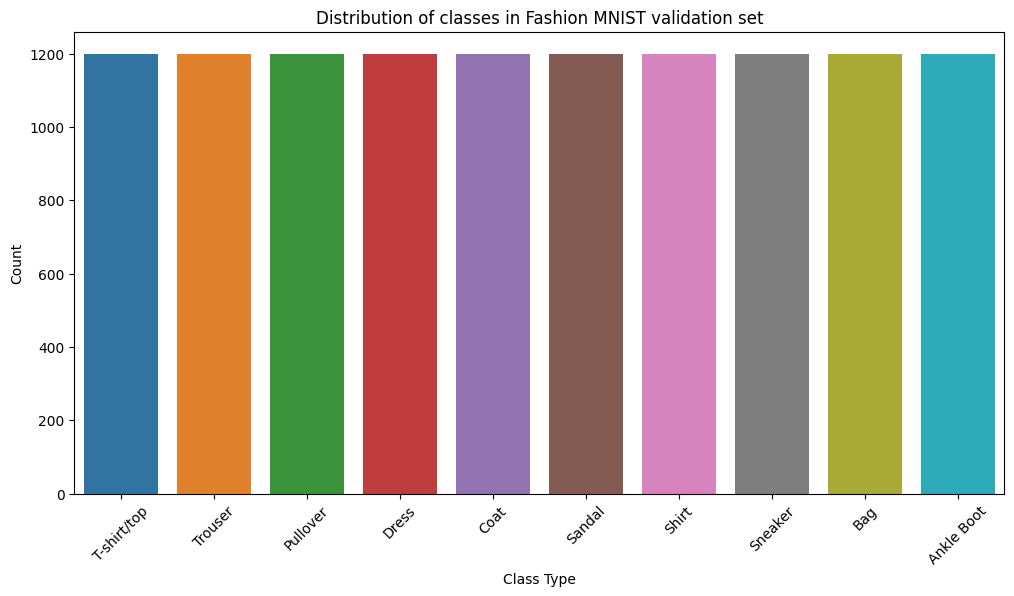

In [14]:
# check the class distribution for validation set
# Count of each label
label_counts = np.bincount(y_val)

# Convert to dict for ease of use
label_counts_dict = {labels[i]: count for i, count in enumerate(label_counts)}

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_dict.keys()), y=list(label_counts_dict.values()))
plt.title('Distribution of classes in Fashion MNIST validation set')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

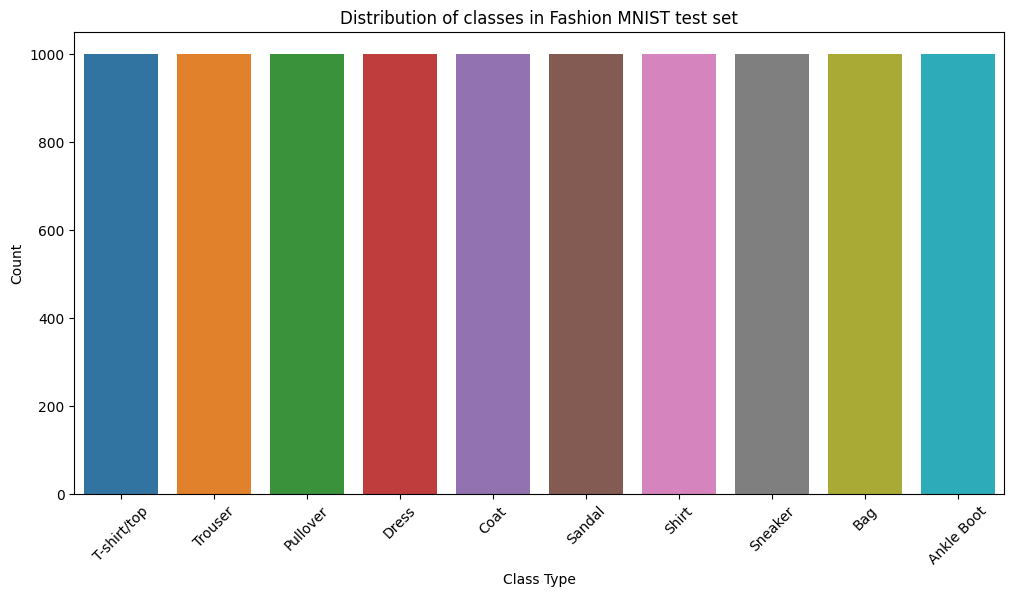

In [15]:
# Check the class distribution for test set
# Count of each label
label_counts = np.bincount(y_test)

# Convert to dict for ease of use
label_counts_dict = {labels[i]: count for i, count in enumerate(label_counts)}

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_dict.keys()), y=list(label_counts_dict.values()))
plt.title('Distribution of classes in Fashion MNIST test set')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 1.3 Data Preprocessing

In [16]:
# Normalize Image Data and Reshaping the data

X_train = X_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0

X_train = np.repeat(X_train, 3, axis=-1)
X_train = tf.image.resize(X_train, [48, 48])

X_val = np.repeat(X_val, 3, axis=-1)
X_val = tf.image.resize(X_val, [48, 48])

X_test = np.repeat(X_test, 3, axis=-1)
X_test = tf.image.resize(X_test, [48, 48])

In [17]:
#print the shape of each subset
print("Training set shape (X, y):", X_train.shape, y_train.shape)
print("Validation set shape (X, y):", X_val.shape, y_val.shape)
print("Test set shape (X, y):", X_test.shape, y_test.shape)

Training set shape (X, y): (48000, 48, 48, 3) (48000,)
Validation set shape (X, y): (12000, 48, 48, 3) (12000,)
Test set shape (X, y): (10000, 48, 48, 3) (10000,)


In [18]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [19]:

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

datagen.fit(X_train)
datagen.fit(X_val)
datagen.fit(X_test)

## 2. CNN


### 2.1 Define the Baseline Model

In [22]:
# Define the model
cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the model.
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,min_delta=0,
                              mode='auto',restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

callbacks = [earlystop, checkpoint]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,mode='auto',
                                  patience=3, min_delta=0.0001,cooldown=2,min_lr=0.0001)
callbacks.append(reduce_lr)

# Summary of the model.
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

### 2.2 Baseline Model Training

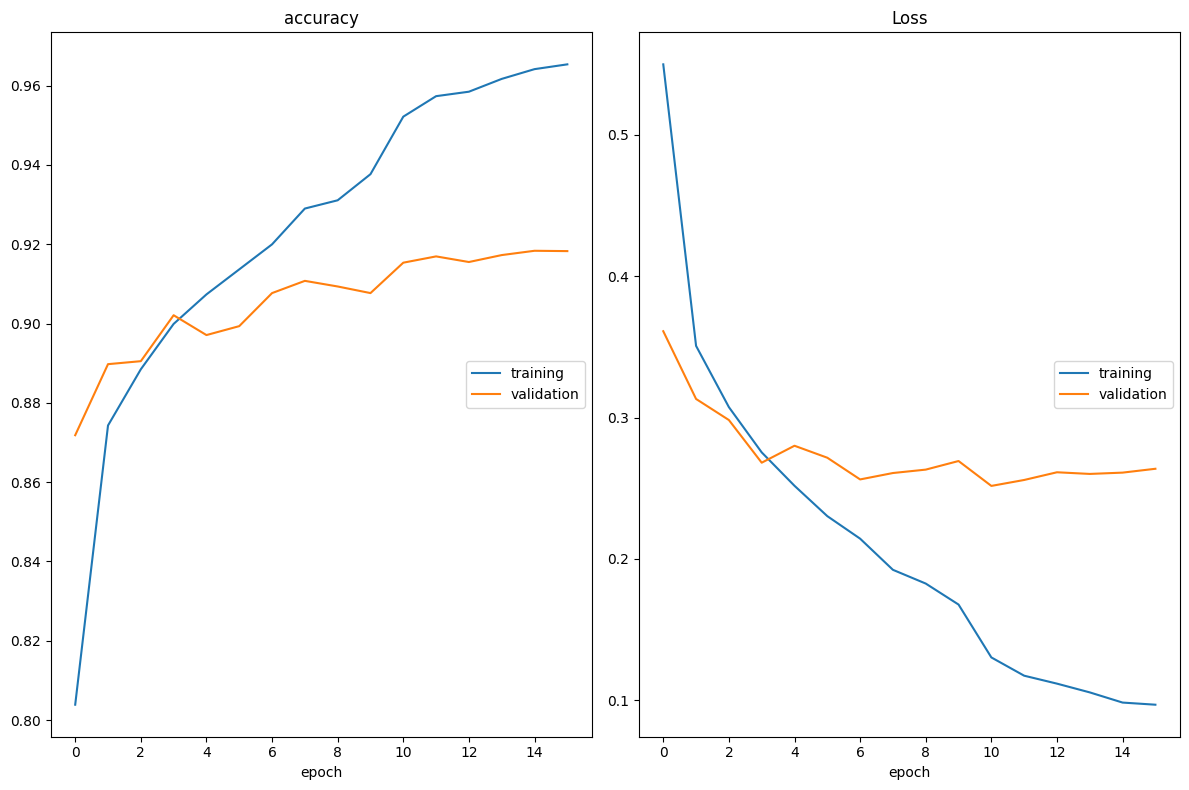

accuracy
	training         	 (min:    0.804, max:    0.965, cur:    0.965)
	validation       	 (min:    0.872, max:    0.918, cur:    0.918)
Loss
	training         	 (min:    0.097, max:    0.550, cur:    0.097)
	validation       	 (min:    0.252, max:    0.361, cur:    0.264)
Restoring model weights from the end of the best epoch: 11.
188/188 [==============================] - 3s 15ms/step - loss: 0.0968 - accuracy: 0.9653 - val_loss: 0.2637 - val_accuracy: 0.9183 - lr: 1.0000e-04
Epoch 16: early stopping


In [11]:
# Prepare the callbacks
plot_losses = PlotLossesCallback()  # for live plotting

# Train the Baseline Model
history_cnn = cnn_model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[plot_losses, checkpoint, earlystop, reduce_lr],
    verbose=1
)



### 2.3 Baseline Model Evaluation

In [22]:
cnn_score = cnn_model.evaluate(X_val, y_val, verbose=0)
print('Baseline Validation loss:', cnn_score[0])
print('Baseline Validation accuracy:', cnn_score[1])

Baseline Validation loss: 0.32832942008972166
Baseline Validation accuracy: 0.898666660785675


### 2.4 Graphical Representation of Baseline Model

In [25]:
# Save model plot to a file.
plot_model(cnn_model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Use the HTML capabilities of IPython.display to add an <img> tag.

# Define the width and height
desired_width = 600
desired_height = 300

# Using HTML, control the size of the display.
img_html = f'<img src="model.png" width="{desired_width}" height="{desired_height}"/>'

# Finally, display the image with the set dimensions.
display(HTML(img_html))


### Comparing Different CNN Module

## 3.1 VGG 11

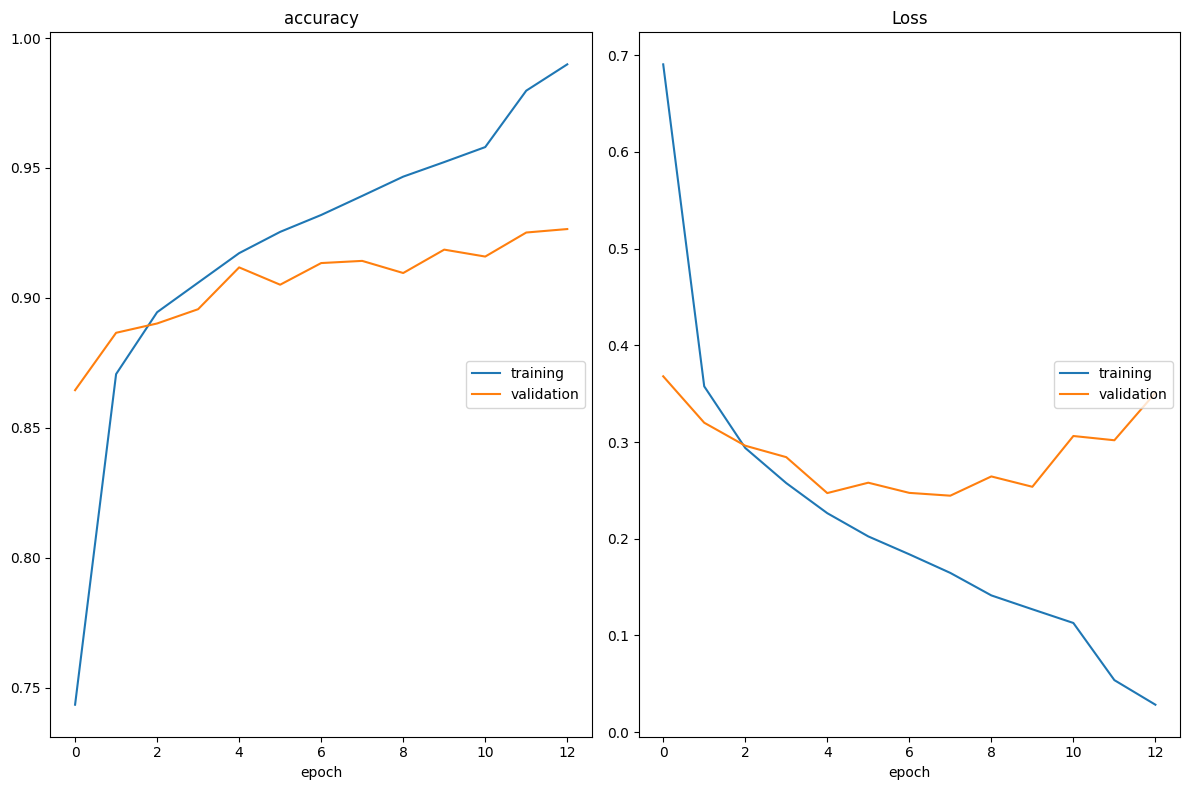

accuracy
	training         	 (min:    0.743, max:    0.990, cur:    0.990)
	validation       	 (min:    0.864, max:    0.927, cur:    0.927)
Loss
	training         	 (min:    0.028, max:    0.690, cur:    0.028)
	validation       	 (min:    0.245, max:    0.368, cur:    0.351)
Restoring model weights from the end of the best epoch: 8.
188/188 [==============================] - 5s 29ms/step - loss: 0.0284 - accuracy: 0.9899 - val_loss: 0.3509 - val_accuracy: 0.9265 - lr: 2.0000e-04
Epoch 13: early stopping


In [14]:
def create_custom_vgg11(input_shape, num_classes, configuration):
    model = Sequential()

    # Adding the convolutional layers and max-pooling layers
    for layer_conf in configuration:
        if layer_conf == 'M':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        else:
            # Reduced the number of filters and used 'same' padding.
            model.add(Conv2D(layer_conf, (3, 3), padding='same', activation='relu'))

    model.add(Flatten())
    # Reduced the size of the fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    return model


configs = {
    'VGG11': [32, 'M', 64, 'M', 128, 128, 'M', 256, 256, 'M', 256, 256, 'M' ]}


for version, config in configs.items():
    print(f"\nTraining and evaluating modified {version} ...")
    vgg11_model = create_custom_vgg11((28, 28, 1), 10, config)

    vgg11_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,min_delta=0,
                              mode='auto',restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,mode='auto',
                                  patience=3, epsilon=0.0001,cooldown=2,min_lr=0.0001)

    # Prepare the callbacks
    plot_losses = PlotLossesCallback()  # for live plotting

    # Train the model
    vgg11_model.fit(X_train,
                  y_train,
                  batch_size=256,
                  epochs=20,
                  validation_data=(X_val, y_val),
                  callbacks=[plot_losses, checkpoint, earlystop, reduce_lr])

In [15]:
vgg11_score = vgg11_model.evaluate(X_val, y_val, verbose=0)
print('Validation loss for VGG11:', vgg11_score[0])
print('Validation accuracy for VGG11:' ,vgg11_score[1])

Validation loss for VGG11: 0.24453401565551758
Validation accuracy for VGG11: 0.9142500162124634


In [16]:
# Summary of the model.
vgg11_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)      

### 3.2 VGG16

In [17]:
def create_custom_vgg16(input_shape=(48, 48, 3), num_classes=10):
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='block1_conv1'),
        MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),

        # Block 2
        Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1'),
        MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),

        # Block 3
        Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1'),
        Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2'),
        MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),

        # Block 4
        Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1'),
        Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2'),
        MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),

        # Block 5
        Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1'),
        Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2'),
        MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'),

        # Classification block
        Flatten(name='flatten'),
        Dense(4096, activation='relu', name='fc1'),
        Dropout(0.5),  # Adding dropout to prevent overfitting
        Dense(4096, activation='relu', name='fc2'),
        Dropout(0.5),  # Adding dropout to prevent overfitting
        Dense(num_classes, activation='softmax', name='predictions')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the VGG11 model
vgg16 = create_custom_vgg16(input_shape=(48, 48, 3), num_classes=10)


# Summary of the model
vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 12, 12, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 6, 6, 256)        

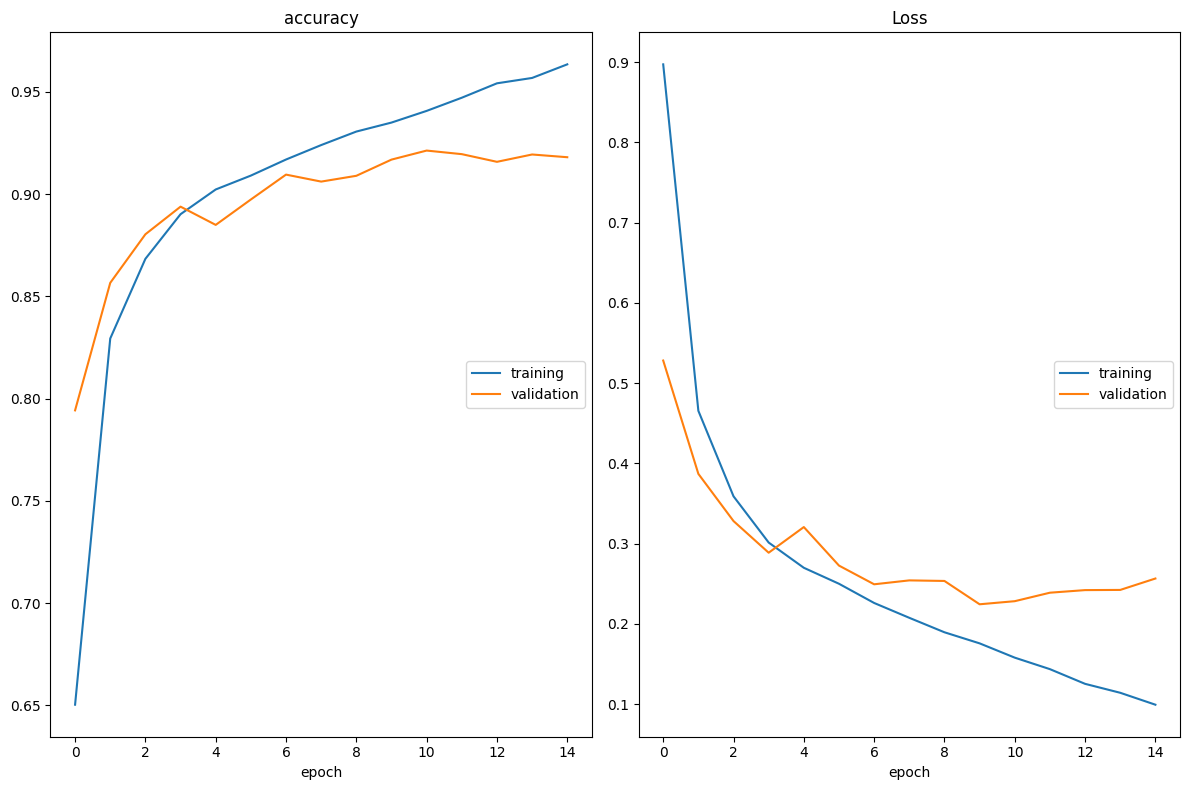

accuracy
	training         	 (min:    0.650, max:    0.963, cur:    0.963)
	validation       	 (min:    0.794, max:    0.921, cur:    0.918)
Loss
	training         	 (min:    0.099, max:    0.897, cur:    0.099)
	validation       	 (min:    0.224, max:    0.528, cur:    0.257)
Restoring model weights from the end of the best epoch: 10.
188/188 [==============================] - 13s 68ms/step - loss: 0.0993 - accuracy: 0.9634 - val_loss: 0.2566 - val_accuracy: 0.9180 - lr: 1.0000e-04
Epoch 15: early stopping


In [18]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,min_delta=0,
                          mode='auto',restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,mode='auto',
                              patience=3, epsilon=0.0001,cooldown=2,min_lr=0.0001)

# Prepare the callbacks
plot_losses = PlotLossesCallback()  # for live plotting

# Train the model
vgg16.fit(X_train,
              y_train,
              batch_size=256,
              epochs=20,
              validation_data=(X_val, y_val),
              callbacks=[plot_losses, checkpoint, earlystop, reduce_lr])


In [19]:
# Evaluate the model
score = vgg16.evaluate(X_val, y_val, verbose=0)
print('Validation loss for VGG16:', score[0])
print('Validation accuracy for VGG16:' ,score[1])

Validation loss for VGG16: 0.2244722694158554
Validation accuracy for VGG16: 0.9168333411216736


### 3.3 Resnet 50

In [23]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    Arguments:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at the main path
    filters: list of integers, the filters of 3 conv layer at the main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = ReLU()(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = ReLU()(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = ReLU()(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    Arguments:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at the main path
    filters: list of integers, the filters of 3 conv layer at the main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    strides: Strides for the first conv layer in the block
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = ReLU()(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = ReLU()(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x


In [24]:
def ResNet50(input_shape=(48, 48, 3), classes=10):
    """Instantiates the ResNet50 architecture.
    Arguments:
    input_shape: shape tuple
    classes: optional number of classes to classify images
    """
    input_tensor = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(input_tensor)
    x = BatchNormalization(name='bn_conv1')(x)
    x = ReLU()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1, 4):
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='b' + str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1, 6):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b' + str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    output_tensor = Dense(classes, activation='softmax', name='fc' + str(classes))(x)

    model = Model(input_tensor, output_tensor, name='resnet50')

    return model


In [25]:
# Create the ResNet50 model.
ResNet50_model = ResNet50(input_shape=(48, 48, 3), classes=10)

# Compile the model.
ResNet50_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Print the model summary.
ResNet50_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 re_lu (ReLU)                   (None, 24, 24, 64)   0           ['bn_conv1[0][0]']               
                                                                                           

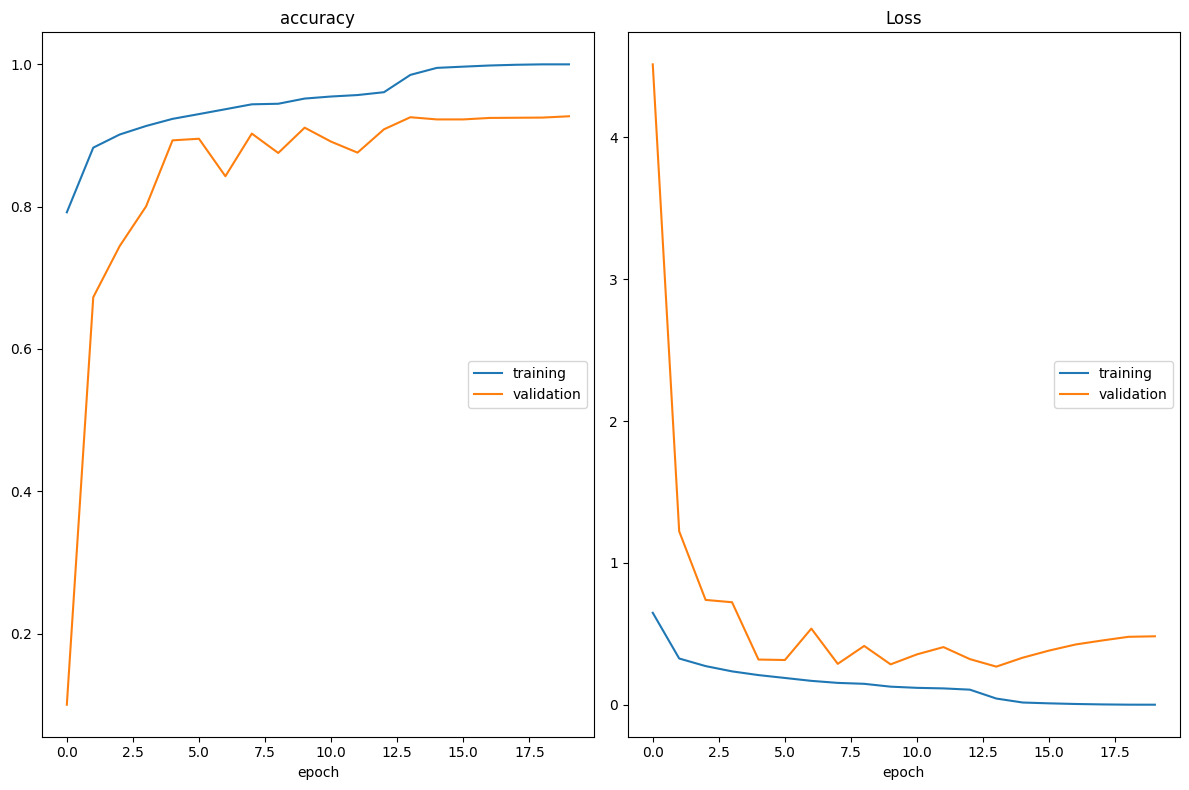

accuracy

	training         	 (min:    0.792, max:    1.000, cur:    1.000)

	validation       	 (min:    0.100, max:    0.927, cur:    0.927)

Loss

	training         	 (min:    0.000, max:    0.648, cur:    0.000)

	validation       	 (min:    0.269, max:    4.515, cur:    0.483)

188/188 [==============================] - 37s 195ms/step - loss: 3.0226e-04 - accuracy: 1.0000 - val_loss: 0.4826 - val_accuracy: 0.9270 - lr: 1.0000e-04


In [ ]:
# Prepare the callbacks
plot_losses = PlotLossesCallback()  # for live plotting

tl_checkpoint = ModelCheckpoint(
    filepath='tl_model_v1.weights.best.hdf5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min'
)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,mode='auto',
                                  patience=3, epsilon=0.0001,cooldown=2,min_lr=0.0001)

# Fit the ResNet model
history = ResNet50_model.fit(
    x=X_train,
    y=y_train,
    batch_size= 256,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[tl_checkpoint, early_stopping, plot_losses, reduce_lr],
    verbose=1
)

In [33]:
# Evaluate the model
ResNet50_score = ResNet50_model.evaluate(X_val, y_val, verbose=0)
print('Validation loss for RESNET:', ResNet50_score[0])
print('Validation accuracy for RESNET:' ,ResNet50_score[1])

Validation loss for RESNET: 0.3562086224555969
Validation accuracy for RESNET: 0.9047499704360962


In [35]:
# Create a DataFrame
results = pd.DataFrame({
    'Model': [ 'Baseline CNN', 'VGG11', 'VGG16', 'ResNet50'],
    'Loss': [ cnn_score[0], vgg11_score[0],score[0], ResNet50_score[0]],
    'Accuracy': [ cnn_score[1],vgg11_score[1], score[1], ResNet50_score[1]]
})

results = results.round(3)

from tabulate import tabulate

# Print the DataFrame using tabulate for a nicer table format
print(tabulate(results, headers='keys', tablefmt='psql', showindex=False))


+--------------+--------+------------+
| Model        |   Loss |   Accuracy |
|--------------+--------+------------|
| Baseline CNN |  0.328 |      0.899 |
| VGG11        |  0.244 |      0.911 |
| VGG16        |  0.224 |      0.916 |
| ResNet50     |  0.356 |      0.904 |
+--------------+--------+------------+


## 4. Manual Hyperparameter Tuning of Best Module

In [26]:
class CustomVGG16HyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp: HyperParameters):
        model = Sequential()

        # Block 1
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=self.input_shape, name='block1_conv1'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

        # Block 2
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

        # Block 3
        model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1'))
        model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

        # Block 4
        model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1'))
        model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

        # Block 5
        model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1'))
        model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2'))
        model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

        # Before Flatten layer, add a GlobalAveragePooling2D layer
        model.add(layers.GlobalAveragePooling2D())

        # Classification block
        model.add(layers.Flatten(name='flatten'))

        # Instead of fixed size, tune the size of Dense layer
        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(layers.Dense(
                units=hp.Int('units_' + str(i), min_value=256, max_value=4096, step=256),
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_regularization', min_value=0.0001, max_value=0.01, default=0.0001, step=0.0001))
            ))
            model.add(layers.Dropout(
                hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05, default=0.25)
            ))

        model.add(layers.Dense(self.num_classes, activation='softmax', name='predictions'))

        # Compilation
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

# Usage:
input_shape = (48, 48, 3)
num_classes = 10

hypermodel = CustomVGG16HyperModel(input_shape=input_shape, num_classes=num_classes)

In [22]:
from kerastuner.tuners import RandomSearch

# Specify the tuner's settings
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner_directory',
    project_name='vgg16_tuning'
)

# Start the search for the best hyperparameters
tuner.search(
    X_train, y_train,
    batch_size= best_hps.get('batch_size') if 'batch_size' in best_hps else 256,
    epochs=best_hps.get('epochs') if 'epochs' in best_hps else 20,
    validation_data=(X_val, y_val)
)


Trial 5 Complete [00h 03m 51s]
val_accuracy: 0.49133332446217537

Best val_accuracy So Far: 0.9222916662693024
Total elapsed time: 00h 20m 17s


In [23]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=20,
    validation_data=(X_val, y_val)
)

# Evaluate the model on the test data
Final_score = model.evaluate(X_test, y_test)

Epoch 1/20
188/188 [==============================] - 15s 59ms/step - loss: 2.0692 - accuracy: 0.7514 - val_loss: 1.0423 - val_accuracy: 0.8611
Epoch 2/20
188/188 [==============================] - 11s 58ms/step - loss: 0.7804 - accuracy: 0.8789 - val_loss: 0.6247 - val_accuracy: 0.8828
Epoch 3/20
188/188 [==============================] - 11s 58ms/step - loss: 0.4842 - accuracy: 0.9004 - val_loss: 0.4182 - val_accuracy: 0.8983
Epoch 4/20
188/188 [==============================] - 11s 58ms/step - loss: 0.3515 - accuracy: 0.9085 - val_loss: 0.3340 - val_accuracy: 0.9069
Epoch 5/20
188/188 [==============================] - 11s 58ms/step - loss: 0.2748 - accuracy: 0.9198 - val_loss: 0.3191 - val_accuracy: 0.8957
Epoch 6/20
188/188 [==============================] - 11s 58ms/step - loss: 0.2323 - accuracy: 0.9268 - val_loss: 0.2543 - val_accuracy: 0.9181
Epoch 7/20
188/188 [==============================] - 11s 58ms/step - loss: 0.1994 - accuracy: 0.9350 - val_loss: 0.2433 - val_accuracy:

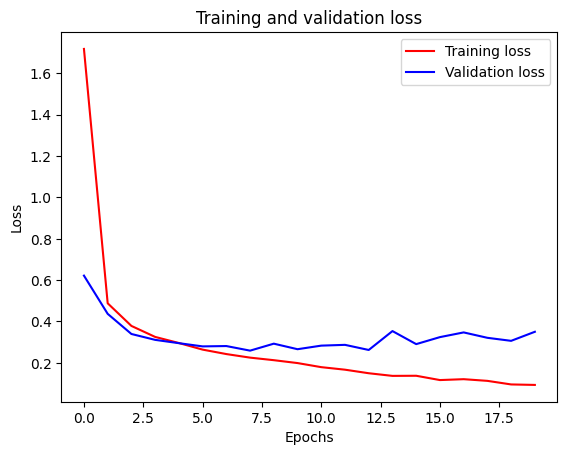

In [ ]:
import matplotlib.pyplot as plt

# Retrieve a list of results on training and validation data sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


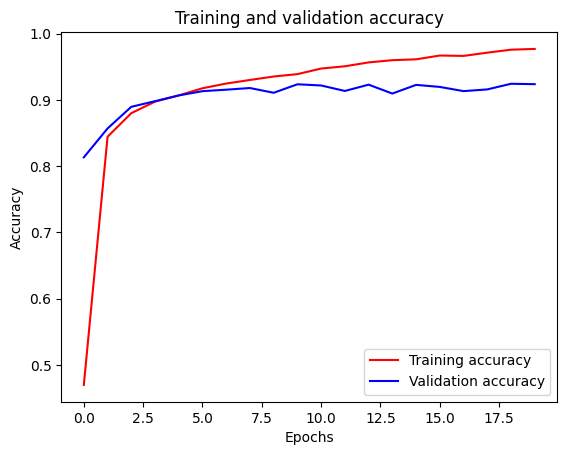

In [ ]:
# Retrieve a list of accuracy results on training and validation data sets for each training epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy per epoch
plt.figure()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get the predictions for the test data
predictions = model.predict(X_test)

# Convert the probabilities into class labels
predicted_classes = np.argmax(predictions, axis=1)

#get the indices to be plotted
y_true = test_data.iloc[:, 0].values
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
# Print the classification report with actual class names
print(classification_report(y_true, predicted_classes, target_names=class_names))

313/313 [==============================] - 2s 7ms/step

              precision    recall  f1-score   support



 T-shirt/top       0.85      0.90      0.87      1000

     Trouser       0.99      0.99      0.99      1000

    Pullover       0.91      0.86      0.89      1000

       Dress       0.96      0.90      0.93      1000

        Coat       0.85      0.91      0.88      1000

      Sandal       0.99      0.98      0.99      1000

       Shirt       0.78      0.77      0.77      1000

     Sneaker       0.97      0.97      0.97      1000

         Bag       0.98      0.98      0.98      1000

  Ankle boot       0.97      0.97      0.97      1000



    accuracy                           0.92     10000

   macro avg       0.93      0.92      0.92     10000

weighted avg       0.93      0.92      0.92     10000




313/313 [==============================] - 4s 12ms/step


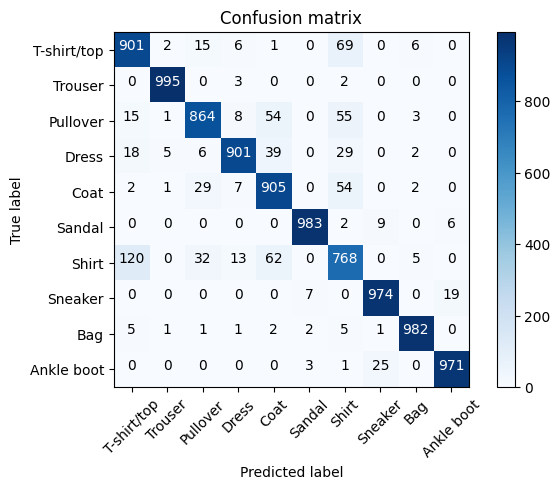

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
# Look at confusion matrix

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred,axis = 1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = class_names)

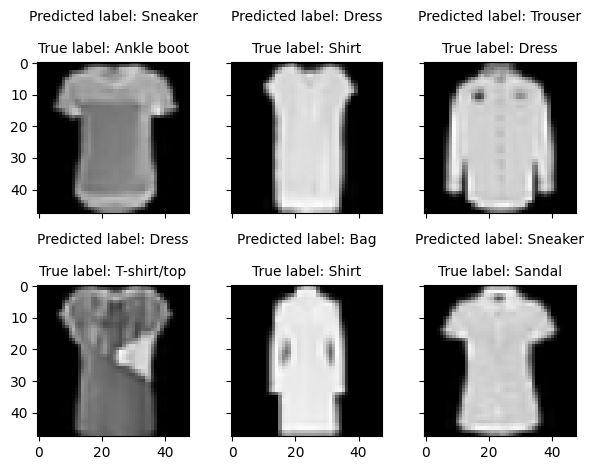

In [ ]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_test_errors = X_test[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            # Convert the tensor to a numpy array before reshaping
            ax[row, col].imshow((img_errors[error].numpy()).reshape((48, 48, 3)))
            # Translate numerical labels into class names
            predicted_label = class_names[pred_errors[error]]
            true_label = class_names[obs_errors[error]]
            ax[row, col].set_title("Predicted label: {}\n \nTrue label: {}".format(predicted_label, true_label), fontsize=10)
            n += 1
            plt.tight_layout()
    plt.show()


# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

In [37]:
print('Loss:', Final_score[0])
print('Accuracy' ,Final_score[1])

Loss: 0.1835386841243512
Accuracy 0.9245347719784531
